In [25]:
import scPhyloX as spx
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import matplotlib.lines as mlines
from Bio import Phylo
import os
from tqdm import tqdm
import pickle
import arviz as az
from copy import deepcopy
from scipy.stats import poisson,mannwhitneyu

In [2]:
plt.rcParams['font.size']=12
plt.rcParams['pdf.fonttype']=42

In [3]:
os.chdir('..')

In [4]:
results = [i for i in os.listdir('./results/hsc') if i[-1]=='l']

In [11]:
colors1 = ['#ff6a00', '#ff812b', '#ff9645', '#ffa95c', '#ffbc73', '#ffcd88', '#ffde9e', '#ffefb3'][::-1]
colors2 = ['#686eab', '#787cb5', '#898cc0', '#999bca', '#a9abd5', '#b9bbdf', '#cacbea', '#dadcf4'][::-1]
cmp1 = dict(zip(np.sort([int(i.split('_')[1].split('.')[0]) for i in results]), colors1))
cmp2 = dict(zip(np.sort([int(i.split('_')[1].split('.')[0]) for i in results]), colors2))

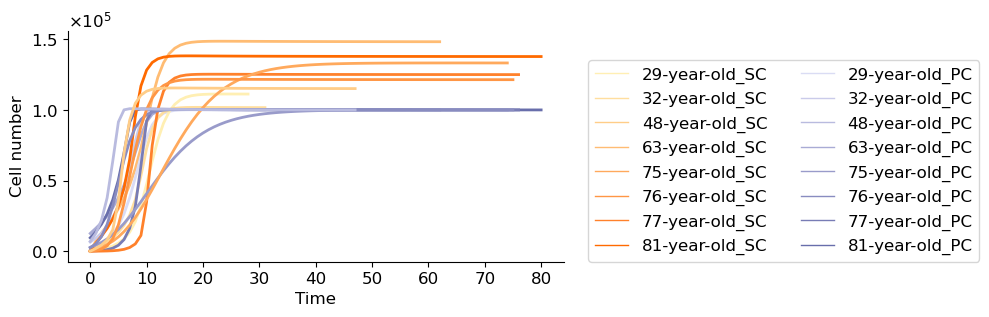

In [22]:
fig, ax = plt.subplots(figsize=(6.4,3))
for i in results:
    res = pickle.load(open(f'./results/hsc/{i}', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
    theta_sd = summary.loc['ax,r,d,k,t0'.split(',')]['sd'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    c0 = 1e5
    T = int(i.split('_')[1].split('.')[0])
    n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    n_noncyclingcells = np.array([[spx.est_tissue.nnc(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    scale = 1e5/n_cyclingcells.sum(0)[-1]
    ax.plot(n_cyclingcells.sum(0)*scale, c=cmp2[T], lw=2, label=i.split('_')[0])
    ax.plot(n_noncyclingcells.sum(0)*scale, c=cmp1[T], lw=2)
lgnds=[]
for i in cmp1.keys():
    lgnds.append(mlines.Line2D([], [], color=cmp1[i],lw=1 ,label=f'{i}-year-old_SC'))
for i in cmp2.keys():
    lgnds.append(mlines.Line2D([], [], color=cmp2[i],lw=1 ,label=f'{i}-year-old_PC'))
ax.set_xlabel('Time')
ax.set_ylabel('Cell number')
ax.ticklabel_format(style='sci', scilimits= (-1,2), axis='y',useMathText=True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
lgnd = ax.legend(handles=lgnds, ncol=2, bbox_to_anchor=(1.05, 0), loc=3, borderaxespad=0) 

In [26]:
para_df = pd.DataFrame(columns='ax,r,d,k,t0'.split(','))
for i in results:
    res = pickle.load(open(f'./results/hsc/{i}', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
    para_df.loc[i.split('.')[0]] = theta_mu
para_df['age'] = [int(i.split('_')[1]) for i in para_df.index]
colless_ind = []
for i in para_df.index:
    file_name = os.listdir(f"./datasets/HSC_lifespan/filtering_output_{i.split('_')[0]}")[0]
    tree = Phylo.read(f"./datasets/HSC_lifespan/filtering_output_{i.split('_')[0]}/{file_name}", format='newick')
    colless_ind.append(np.mean(spx.utils.colless_index(tree)))
para_df['colless_index'] = colless_ind

In [30]:
sc_frac = []
for i in para_df.index:
    res = pickle.load(open(f'./results/hsc/{i}.pkl', 'rb'))
    summary = az.summary(res)
    theta_mu = summary.loc['ax,r,d,k,t0'.split(',')]['mean'].to_numpy().tolist()
    theta_h = deepcopy(theta_mu)
    theta_h.insert(1,1)
    
    c0 = 1e5
    T = int(i.split('_')[1].split('.')[0])
    n_cyclingcells = np.array([[spx.est_tissue.ncyc(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    n_noncyclingcells = np.array([[spx.est_tissue.nnc(i, j, c0, *theta_h) for j in range(T)] for i in range(120)])
    sc_frac.append(n_cyclingcells[:, -1].sum() / (n_noncyclingcells[:, -1].sum()+n_cyclingcells[:, -1].sum()))
para_df['sc_frac'] = sc_frac

Text(0.5, 0, 'Age')

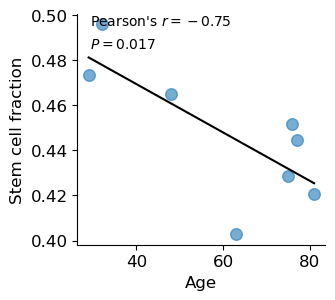

In [31]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(para_df['age'], para_df['sc_frac'], ax=ax, stats='pearson', line='fit', alternative='less')
ax.set_ylabel('Stem cell fraction')
ax.set_xlabel('Age')

Text(0.5, 0, 'Age')

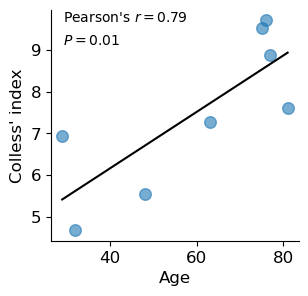

In [32]:
fig, ax = plt.subplots(figsize=(3.2,3))
spx.utils.corr_plot(para_df['age'], para_df['colless_index'], ax=ax, stats='pearson', line='fit', alternative='greater')
ax.set_ylabel('Colless\' index')
ax.set_xlabel('Age')